In [ ]:
# import libraries

import re
import torch
import torch.nn as nn
import numpy as np

import json
import matplotlib.pyplot as plt
import json


from utils.config import JSON_FILE_SEEDS_SUPPFIG7, SIMULATION_TEST_OUTPUT_FOLDER_2, SIMULATION_TEST_INPUT_FOLDER_2
from utils.config import MODEL_DILRESNET_FIG2
from utils.preprocess import preprocess_simulation_input_data,preprocess_simulation_output_data
from models.dilResNet import PDEArenaDilatedResNet
from models.vae import decode_img

from utils.display import compute_ssim_high_precision
from utils.display import tensor_to_pil_v2

/hpc/dctrl/ks723/miniconda3/envs/pytorch_PA_patternprediction/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[2025-11-18 13:57:48,555] [INFO] [real_accelerator.py:110:get_accelerator] Setting ds_accelerator to cuda (auto detect)


/hpc/dctrl/ks723/miniconda3/envs/pytorch_PA_patternprediction/lib/python3.10/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [ ]:

# Paths and configuration
output_file = JSON_FILE_SEEDS_SUPPFIG7
datadir_i = SIMULATION_TEST_OUTPUT_FOLDER_2  
datadir_o = SIMULATION_TEST_INPUT_FOLDER_2        

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load seed counts from JSON
with open(output_file, 'r') as f:
    seed_counts = json.load(f)

# Limit to 1000 images for this test
input_seed_keys = list(seed_counts.keys())[:1000]

In [ ]:
"""Load the seeedcount file, images -> use trained model to generate latents -> decode latents to images-> compute SSIM with ground truth images -> plot SSIM vs seed count"""

# Paths and configuration
output_file = JSON_FILE_SEEDS_SUPPFIG7
   

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load seed counts from JSON
with open(output_file, 'r') as f:
    seed_counts = json.load(f)

# Limit to 1000 images for this test
input_seed_keys = list(seed_counts.keys())[:1000]



# Load trained model
# Example usage
model = PDEArenaDilatedResNet(
    in_channels=3,               # Input channels 
    out_channels=4,              # Output channels 
    hidden_channels=64,          # Number of hidden channels
    num_blocks=15,               # Number of dilated blocks 
    dilation_rates=[1, 2, 4, 8], # Dilation rates for multi-scale feature capture
    activation=nn.ReLU,          # Activation function
    norm=True                    # Use BatchNorm after each convolution
)

model.load_state_dict(torch.load(MODEL_DILRESNET_FIG2))
model.to(device)
model.eval()


# Initialize lists
ssim_values = []
seed_count_list = []



# convert input keys list to corresponding output keys list 

ground_truth_keys=[]
for input_seed_key in input_seed_keys:
    ground_truth_key = re.sub(r'^Input', 'Output', input_seed_key)
    ground_truth_keys.append(ground_truth_key)

# Now load images by using supplied lists and preprocessing functions 

output_data=preprocess_simulation_output_data(SIMULATION_TEST_OUTPUT_FOLDER_2, 0,len(ground_truth_keys), ground_truth_keys)
input_data=preprocess_simulation_input_data(SIMULATION_TEST_INPUT_FOLDER_2,0,len(input_seed_keys), input_seed_keys)

X=output_data
y=input_data

X=(np.array(X).reshape(-1,1,256,256)) #/255.0  # last one is grayscale first minus one is all x
y=(np.array(y).reshape(-1,1,32,32)) #/255.0


X=X/255.0 
y=y/255.0

X = torch.Tensor(X)
y = torch.Tensor(y)

y3=y.repeat(1, 3, 1, 1)

# Generate predictions in chunks to avoid OOM
batch_size = 32  
total_samples = y3.shape[0]
predicted_latents_list = []

print(f"Processing {total_samples} samples in batches of {batch_size}")

with torch.no_grad():
    for i in range(0, total_samples, batch_size):
        end_idx = min(i + batch_size, total_samples)
        batch = y3[i:end_idx].to(device)
        
        # print(f"Processing batch {i//batch_size + 1}/{(total_samples + batch_size - 1)//batch_size}")
        
        # Generate predictions for this batch
        predicted_latents_batch = model(batch)
        predicted_latents_list.append(predicted_latents_batch.cpu())
        
        # Clear GPU cache
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

# Concatenate all predicted latents
predicted_latents = torch.cat(predicted_latents_list, dim=0)
predicted_latents_rescaled = predicted_latents

# Decode images in chunks to avoid OOM during VAE decoding
decode_batch_size = 16  # Smaller batch size for VAE decoding - adjust as needed
pred_images_list = []

print(f"Decoding {predicted_latents.shape[0]} latents in batches of {decode_batch_size}")

for i in range(0, predicted_latents.shape[0], decode_batch_size):
    end_idx = min(i + decode_batch_size, predicted_latents.shape[0])
    latent_batch = predicted_latents_rescaled[i:end_idx]
    
    # Decode this batch
    pred_images_batch = decode_img(latent_batch)
    pred_images_list.append(pred_images_batch.cpu())
    
    # Clear GPU cache
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

# Concatenate all decoded images
pred_images = torch.cat(pred_images_list, dim=0)


Processing 1000 samples in batches of 32
Decoding 1000 latents in batches of 16


Calculating SSIM values...


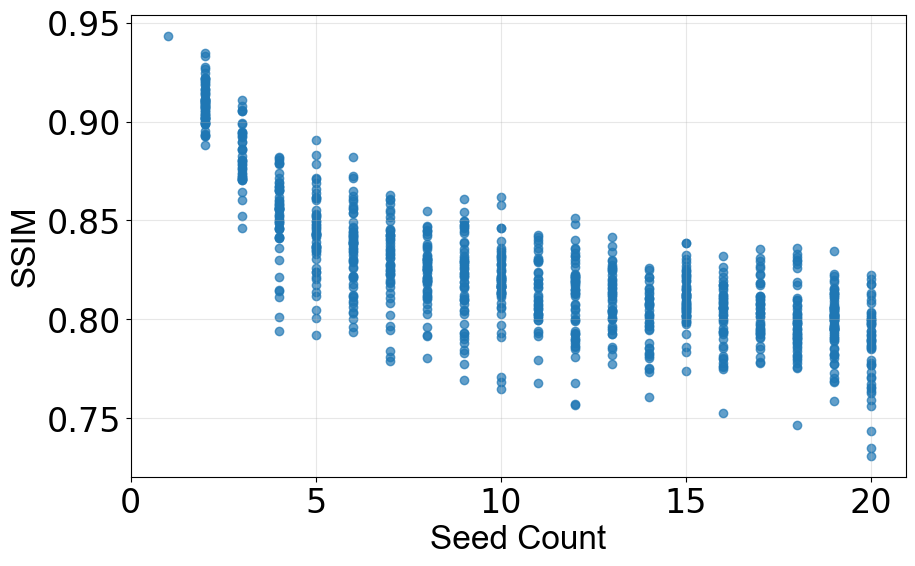


SSIM Statistics:
Mean SSIM: 0.824
Std SSIM: 0.035
Min SSIM: 0.731
Max SSIM: 0.943
Seed count range: 1 - 20


In [6]:
"""Calculate SSIM for each image pair and create scatter plot"""

from pathlib import Path
import matplotlib as mpl

# remove this command if you do not have access to this directory
fpath = Path(mpl.get_data_path(), "/hpc/group/youlab/ks723/miniconda3/Lingchong/fonts/ARIAL.TTF")

# Now calculate SSIM for each image pair
ssim_values = []
seed_count_list = []

print("Calculating SSIM values...")

# Compute SSIM using high precision function
ssim_values = compute_ssim_high_precision(X, pred_images)


for i in range(len(input_seed_keys)):
    # Get seed count for this image
    input_seed_key = input_seed_keys[i]
    seed_count_list.append(seed_counts[input_seed_key])

# if (i + 1) % 100 == 0:
    # print(f"Processed {i + 1}/{len(input_seed_keys)} images")

# print(f"Completed SSIM calculation for {len(ssim_values)} images")

# Plot SSIM values as a function of seed count
plt.figure(figsize=(10, 6))
plt.scatter(seed_count_list, ssim_values, alpha=0.7)
plt.xlabel('Seed Count', fontsize=24,font=fpath)
plt.ylabel('SSIM', fontsize=24,font=fpath)
# plt.title('SSIM as a Function of Seed Count (1000 Images)', fontsize=20,font=fpath)
plt.xticks([0, 5, 10, 15, 20], fontsize=24)  # Set x-tick positions and fontsize
plt.yticks(fontsize=24)  # Set y-tick fontsize

plt.grid(True, alpha=0.3)
plt.show()

# Print some statistics
print(f"\nSSIM Statistics:")
print(f"Mean SSIM: {np.mean(ssim_values):.3f}")
print(f"Std SSIM: {np.std(ssim_values):.3f}")
print(f"Min SSIM: {np.min(ssim_values):.3f}")
print(f"Max SSIM: {np.max(ssim_values):.3f}")
print(f"Seed count range: {min(seed_count_list)} - {max(seed_count_list)}")

/tmp/ipykernel_1583212/3814950582.py:36: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(hspace=0.001, wspace=0.001)


Ground Truth Seed Count: 1
Ground Truth Seed Count: 4
Ground Truth Seed Count: 7
Ground Truth Seed Count: 10
Ground Truth Seed Count: 13
Ground Truth Seed Count: 16
Ground Truth Seed Count: 20


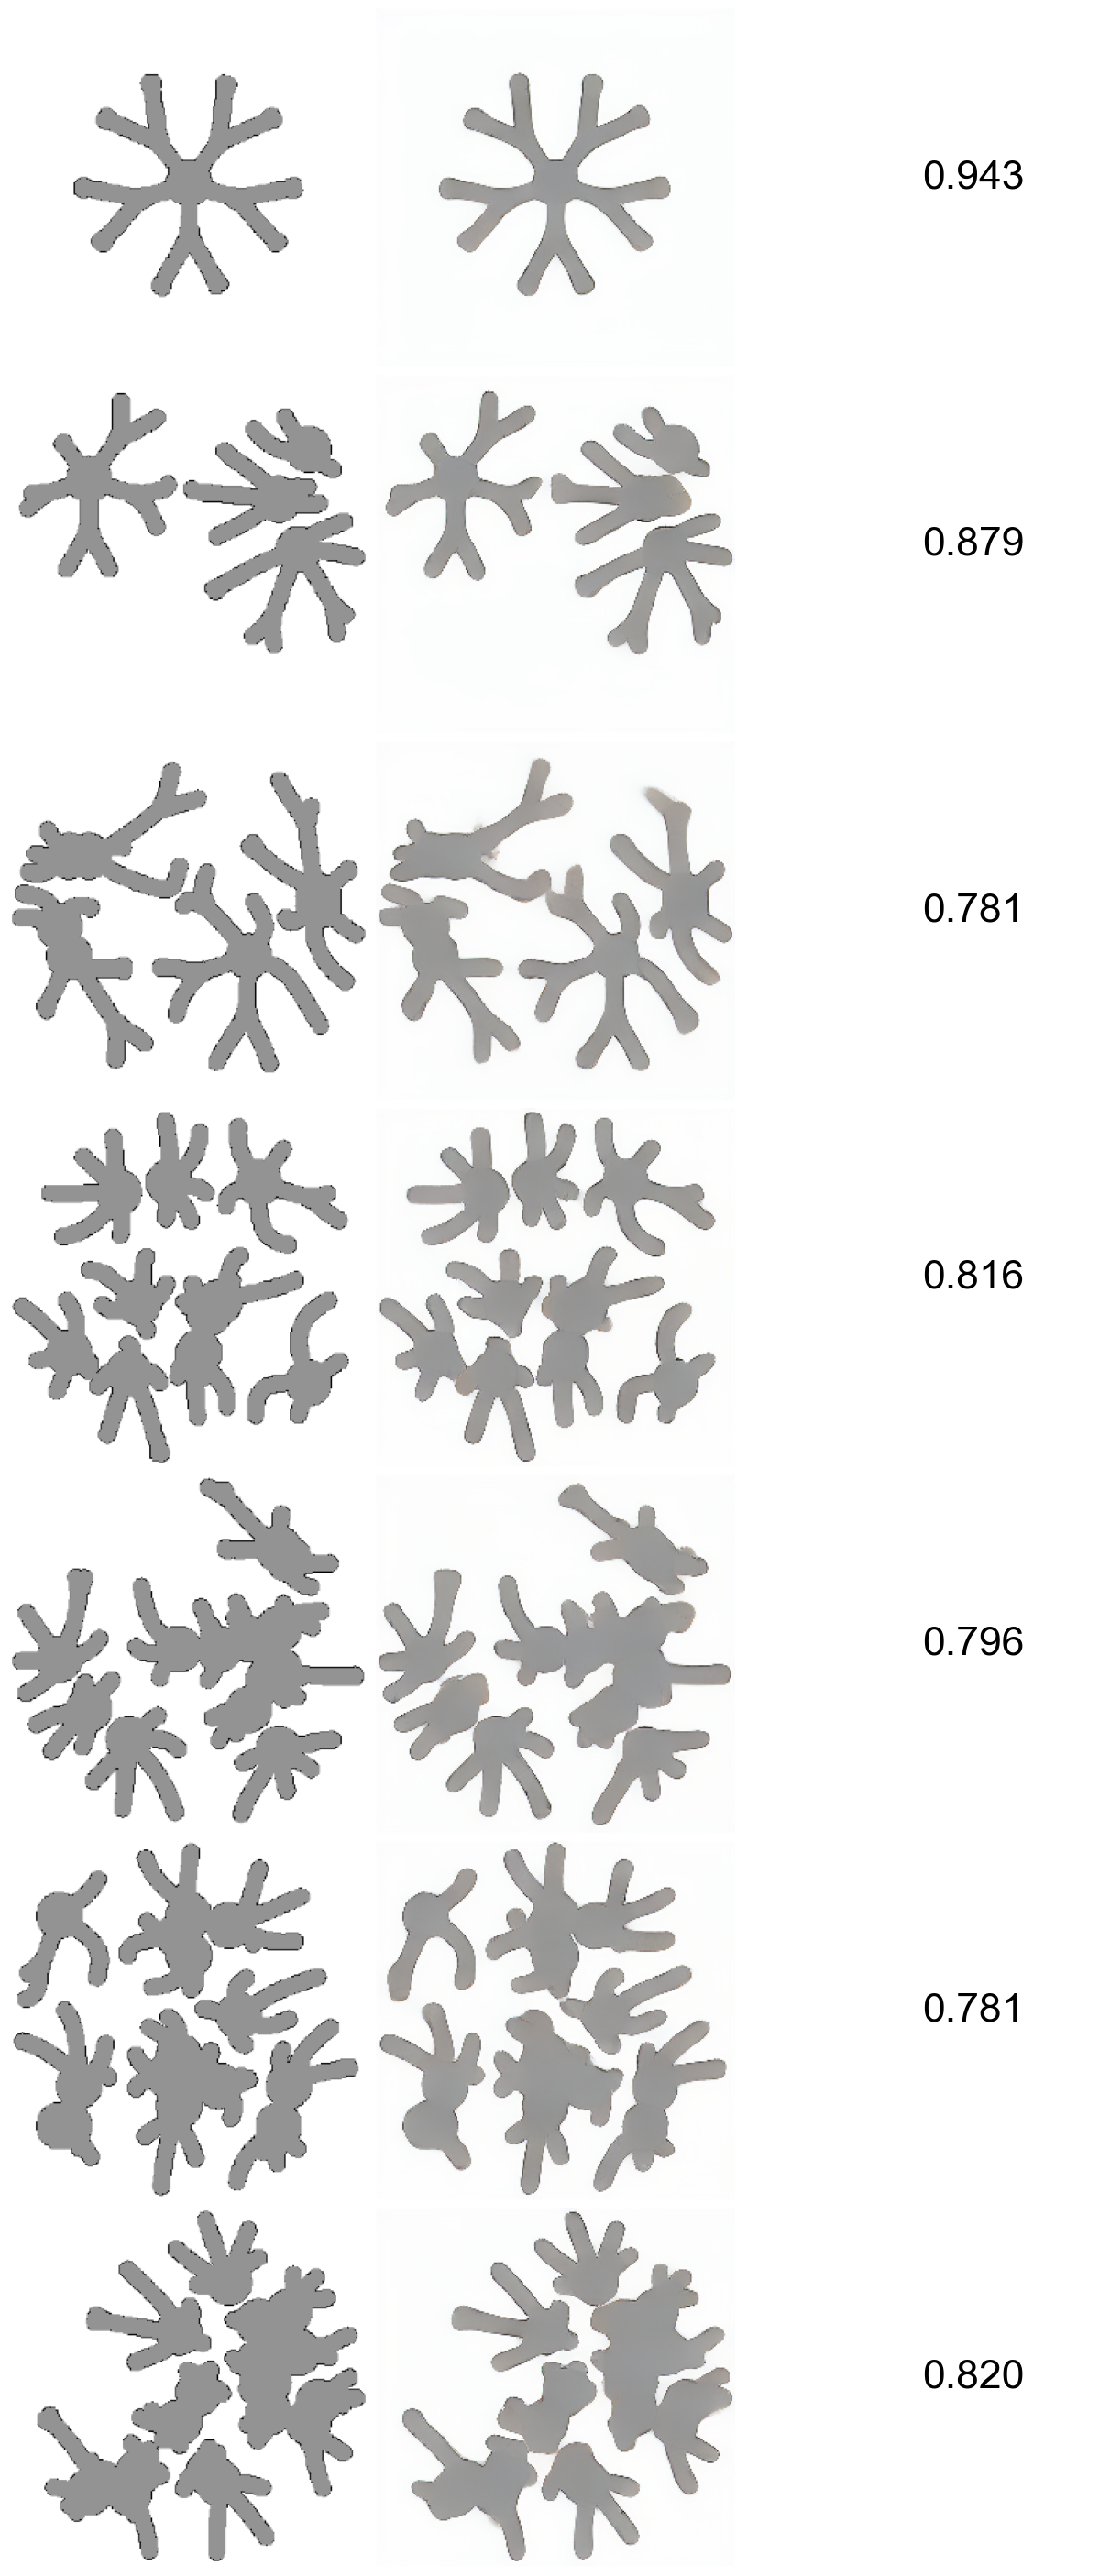

In [7]:
"""Display the SSIM scores for the various image pairs, increasing in complexity from 1 seed to 20 seeds"""

# Now select 5 images with increasing seed counts
# Get unique seed counts and sort them
unique_seed_counts = sorted(set(seed_count_list))
num_samples = 7

# Select 5 seed counts evenly spaced across the range
selected_seed_counts_values = np.linspace(unique_seed_counts[0], unique_seed_counts[-1], num_samples, dtype=int)
selected_indices = []

# For each selected seed count, find an image with that seed count or the closest one
for sc in selected_seed_counts_values:
    # Find indices of images with the exact seed count
    indices_with_sc = [i for i, count in enumerate(seed_count_list) if count == sc]
    if indices_with_sc:
        selected_indices.append(indices_with_sc[0])
    else:
        # If no exact match, find the closest seed count
        closest_index = min(range(len(seed_count_list)), key=lambda i: abs(seed_count_list[i] - sc))
        selected_indices.append(closest_index)


    

# Now collect the selected images and SSIM values
selected_ground_truth_images = [X[i] for i in selected_indices]
selected_predicted_images = [pred_images[i] for i in selected_indices]
selected_ssim_values = [ssim_values[i] for i in selected_indices]
selected_seed_counts = [seed_count_list[i] for i in selected_indices]

# Function to display images with SSIM values
def display_images_with_ssim_map(ground_truth_images, predicted_images, ssim_values, seed_counts):
    num_samples = len(ground_truth_images)
    fig, axes = plt.subplots(num_samples, 3, figsize=(12, num_samples * 4),layout='constrained')
    fig.subplots_adjust(hspace=0.001, wspace=0.001)

    for i in range(num_samples):
        gt_image = ground_truth_images[i]
        pred_image = predicted_images[i]
        ssim_value = ssim_values[i]
        seed_count = seed_counts[i]

        axes[i, 0].imshow(tensor_to_pil_v2(gt_image), cmap='gray')
        axes[i, 0].axis('off')
        print(  f'Ground Truth Seed Count: {seed_count}')
        # axes[i, 0].set_title(f'Ground Truth\nSeed Count: {seed_count}')

        axes[i, 1].imshow(tensor_to_pil_v2(pred_image), cmap='gray')
        axes[i, 1].axis('off')
        # axes[i, 1].set_title('Predicted Image')

        axes[i, 2].text(0.5, 0.5, f'{ssim_value:.3f}',fontsize=32,font=fpath) #f'SSIM: {ssim_value:.3f}', ha='center', va='center', fontsize=24
        axes[i, 2].axis('off')
        # axes[i, 2].set_title('SSIM Value')

    # plt.tight_layout()
    plt.show()

# Display the selected images and SSIM values
display_images_with_ssim_map(selected_ground_truth_images, selected_predicted_images, selected_ssim_values, selected_seed_counts)
